## Feature (Engineering) Regressions using ML/DL Algorithms

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys, os, time, math
import h5py 
sys.path.append('/home/groups/ZuckermanLab/jalim/instalLocal/celltraj/celltraj')
import jcTrajectory_CP as cellTraj
import pickle, subprocess
import umap, scipy, json 
from csaps import csaps
import string, ast 
from joblib import dump, load
from datetime import date
from mpl_toolkits.axes_grid1 import make_axes_locatable

2024-08-22 10:15:37.596951: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-22 10:15:37.621614: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 10:15:37.655852: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 10:15:37.665598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-22 10:15:37.690706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instru

In [2]:
from sklearn.datasets import make_classification, make_regression
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression, LassoCV, ElasticNetCV, SGDRegressor
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, mutual_info_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_class_weight

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Reshape, Dense, Input, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [4]:
trajl = 1
today = date.today()
date2day = today.strftime("%b%d-%Y")
sysName = 'LI204601_P'
figid = f"{sysName}_{date2day}"

In [5]:
fovs = ['A2_1', 'A2_2', 'A2_3', 'B2_1', 'B2_3', 'B2_4']
nfovs = len(fovs)
pathSet = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/'
modelList = [None]*(nfovs)
modelList_conditions = np.zeros(nfovs).astype(int)

In [6]:
for i in range(nfovs):
    modelList_conditions[i] = i
    modelList[i] = f"{pathSet}{sysName}_{fovs[i]}"
    #print("Model Info: ",modelList[i])

nmodels = len(modelList)
modelSet = [None]*nmodels
indgood_models = np.array([]).astype(int)

In [7]:
for i in range(nmodels):
    try:
        objFile = modelList[i]+'.obj'
        objFileHandler = open(objFile,'rb')
        modelSet[i] = pickle.load(objFileHandler)
        print(f"loaded {objFile} with {modelSet[i].cells_indSet.size} cells")
        objFileHandler.close()
        test = len(modelSet[i].linSet)
        indgood_models = np.append(indgood_models, i)
    except:
        print("ERROR in reading *.obj files")
        sys.exit(0)

loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_1.obj with 51054 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_2.obj with 97764 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_A2_3.obj with 58579 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_1.obj with 67836 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_3.obj with 57884 cells
loaded /home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/segsCellPose/bayesianTrackTest/LI204601_P_B2_4.obj with 46096 cells


In [8]:
n_frames = 193 # Total number of frames (image snapshots) in one condition per FOVs
cellnumber_stdSet = np.ones(nmodels)*np.inf
# range of frame indices where cell numbers are higher: ~70-98%
sframe = 70.*n_frames/100.; sframe = math.ceil(sframe)
eframe = 98.5*n_frames/100.; eframe = math.ceil(eframe)
cellnumber_frames = np.arange(sframe, eframe).astype(int)
cellnumber_std_cut = .50 # This was set to 0.10 by Jeremy 
frames = np.arange(n_frames)
# Abscissas at which smoothing will be done using CSAPS package
abSmooth = np.linspace(frames[0], frames[-1], 10000)

In [9]:
for i in indgood_models:
    ncells = np.zeros(n_frames)
    ncells_smooth = np.zeros_like(ncells)
    for iS in range(n_frames):
        ncells[iS] = np.sum(modelSet[i].cells_frameSet == iS)
    # Cubic Spline Approximation (CSAPS) to smoothen the data
    splfov = csaps(frames, ncells/ncells[0], abSmooth, smooth = 0.98) # Scaled by ncells[0] to avoid large numbers
    ncells_smooth = splfov*ncells[0] # smoothened cell numbers reverse scaled back to original
    cellnumber_std = np.std(ncells[cellnumber_frames] - ncells_smooth[cellnumber_frames])/np.mean(ncells[cellnumber_frames])
    cellnumber_stdSet[i] = cellnumber_std # Standard Deviation in Cell Numbers		

In [10]:
indhigh_std = np.where(cellnumber_stdSet > cellnumber_std_cut)[0]
indgood_models = np.setdiff1d(indgood_models, indhigh_std)
for i in indgood_models:
    modelSet[i].Xf[np.isnan(modelSet[i].Xf)] = 0.0

In [11]:
n_COMfeatures = 3
Xf_com0 = np.zeros((0, n_COMfeatures))
for i in indgood_models:
    Xf_com0 = np.append(Xf_com0,modelSet[i].Xf_com, axis = 0)

av_dx = np.nanmean(Xf_com0[:, 0])
std_dx = np.nanstd(Xf_com0[:, 0])
for i in indgood_models:
    modelSet[i].Xf_com[:, 0] = (modelSet[i].Xf_com[:, 0] - av_dx)/std_dx

In [12]:
wctm = cellTraj.Trajectory() # import Trajectory object 
# Cell features: Zernike (49), Haralick (13), Shape (15), Boundary (15) --> total 92
n_features = modelSet[indgood_models[0]].Xf.shape[1]
Xf = np.zeros((0, n_features))
indtreatment = np.array([])
indcellSet = np.array([])

for i in indgood_models:
    Xf = np.append(Xf, modelSet[i].Xf, axis = 0)
    # Indices for each model for later access using them
    indtreatment = np.append(indtreatment, i*np.ones(modelSet[i].Xf.shape[0])) 
    indcellSet = np.append(indcellSet, modelSet[i].cells_indSet)

indtreatment = indtreatment.astype(int)
indcellSet = indcellSet.astype(int)

In [13]:
for i in indgood_models:
    indsf = np.where(indtreatment == i)[0]
    modelSet[i].Xf = Xf[indsf, :]

In [14]:
self = wctm
all_trajSet = [None]*nmodels
for i in indgood_models:
    print(f"Get single-cell trajectories of model: {i}")
    modelSet[i].get_unique_trajectories()
    all_trajSet[i] = modelSet[i].trajectories.copy()

Get single-cell trajectories of model: 0
tracked cell 50891, 25 tracks, 46600 left
tracked cell 50763, 23 tracks, 42400 left
tracked cell 50735, 51 tracks, 41500 left
tracked cell 50076, 1 tracks, 37700 left
tracked cell 49741, 1 tracks, 37600 left
tracked cell 49307, 1 tracks, 37500 left
tracked cell 49056, 18 tracks, 37400 left
tracked cell 48763, 1 tracks, 37100 left
tracked cell 48214, 1 tracks, 36900 left
tracked cell 48008, 1 tracks, 36800 left
tracked cell 47562, 1 tracks, 36500 left
tracked cell 46286, 1 tracks, 35900 left
tracked cell 46119, 3 tracks, 35700 left
tracked cell 45624, 1 tracks, 35600 left
tracked cell 42924, 7 tracks, 34200 left
tracked cell 41889, 2 tracks, 33800 left
tracked cell 41728, 1 tracks, 33700 left
tracked cell 40948, 1 tracks, 33300 left
tracked cell 39770, 1 tracks, 32900 left
tracked cell 39018, 1 tracks, 32500 left
tracked cell 38257, 1 tracks, 32300 left
tracked cell 38063, 6 tracks, 32200 left
tracked cell 37504, 1 tracks, 32000 left
tracked cell

## Load Cell Features & Labels Extracted from O2VAE (https://github.com/directysj/o2vae.git)

In [15]:
num_latent_dim=256
for i in indgood_models:
    data_vae = np.load(f'../o2vae/features_vae{num_latent_dim}_LI204601_{fovs[i]}.npz')
    features_vae = data_vae['embeddings'] # Latent space (bottleneck) features from O2VAE
    labels_vae = data_vae['labels']
    modelSet[i].Xf_vae = features_vae

## Discretize the latent features using histogram binning

In [16]:
Z = modelSet[0].Xf_vae
Z_discrete = np.zeros_like(Z)
for i in range(num_latent_dim):
    hist, bins = np.histogram(Z[:, i], bins=10)
    Z_discrete[:, i] = np.digitize(Z[:, i], bins)

In [17]:
mutual_info = np.zeros((num_latent_dim, num_latent_dim))
for i in range(num_latent_dim):
    for j in range(i+1, num_latent_dim):
        mutual_info[i, j] = mutual_info_score(Z_discrete[:, i], Z_discrete[:, j])
        mutual_info[j, i] = mutual_info[i, j]

## Plot the mutual information matrix as a heatmap

<Figure size 640x480 with 0 Axes>

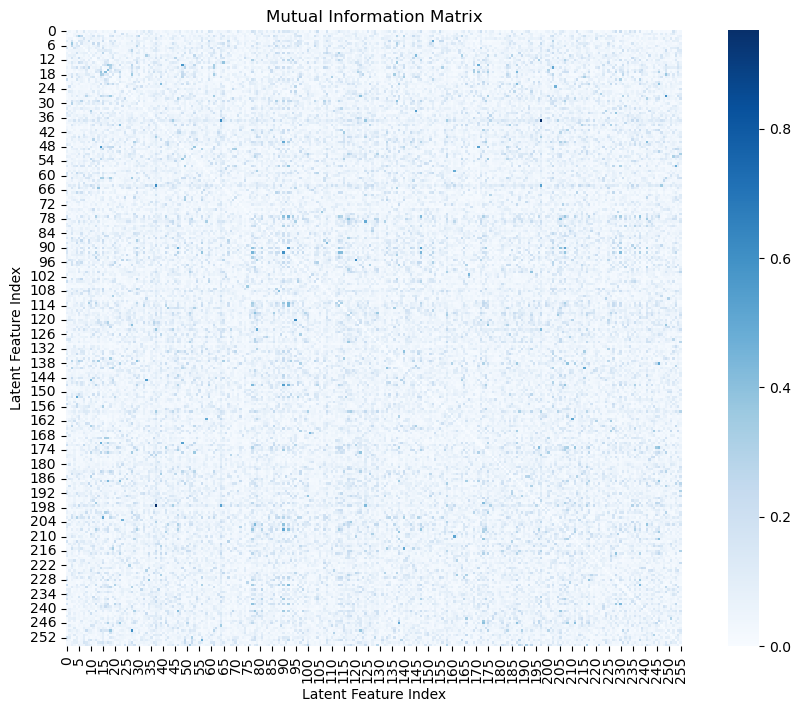

In [36]:
plt.clf()
plt.figure(figsize=(12, 8))
sns.heatmap(mutual_info, cmap="Blues", square=True)
plt.xlabel("Latent Feature Index")
plt.ylabel("Latent Feature Index")
plt.title("Mutual Information Matrix")
plt.show()

In [19]:
# Get snippets along with their full single-cell trajectory indices  
def get_snippets_with_traj_inds(self, seg_length): 
    n_sctraj = len(self.trajectories) # Number of Single-Cell Trajectories 
    traj_segSet = np.zeros((0, seg_length)).astype(int)
    ind_map_snippet_fulltraj = np.array([])
    for ind_traj in range(n_sctraj):
        cell_traj = self.trajectories[ind_traj] # Select a single-cell trajectory
        traj_len = cell_traj.size
        #print("Length of a Single-Cell Trajectory:",traj_len)
        if traj_len >= seg_length:
            for ic in range(traj_len - seg_length):
                traj_seg = cell_traj[ic:ic+seg_length]
                traj_segSet = np.append(traj_segSet, traj_seg[np.newaxis, :], axis = 0)
                # Save indices of all snippets corresponding to "FULL" single-cell trajectory 
                ind_map_snippet_fulltraj = np.append(ind_map_snippet_fulltraj, ind_traj)
                #print("Indices to map snippets to the full trajectory:",ind_map_snippet_fulltraj)
    return ind_map_snippet_fulltraj, traj_segSet

## Stitch Cell Features Along Single-cell Trajectories

In [20]:
#Xf_traj = np.zeros((0, n_features*trajl + n_COMfeatures*trajl))
Xf_traj = np.zeros((0, modelSet[0].Xf_vae.shape[1]*trajl))
indtreatment_traj = np.array([])
indstack_traj = np.array([])
indframes_traj = np.array([])
indmodel_traj_snippets = np.array([])
for i in indgood_models:
    print(f'Building trajectory data for model: {i}')
    modelSet[i].trajectories = all_trajSet[i].copy() # ALL Single-Cell trajectories 
    modelSet[i].trajl = trajl # Trajectory snippet length 
    # Get trajectory snippets of (all trajectories) a given length in a sliding window and mapped with single-cell trajectory indices 
    modelSet[i].snippet_map_fulltraj_inds, modelSet[i].traj = get_snippets_with_traj_inds(modelSet[i], trajl)
    # Xpca (feature info) along the single-cell trajectory snippets, extracted directly from cell indices unique within a 'model' 
    data = modelSet[i].Xf_vae[modelSet[i].traj, :] 
    #datacom = modelSet[i].Xf_com[modelSet[i].traj, :]
    data = data.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_vae.shape[1]*trajl)
    #datacom = datacom.reshape(modelSet[i].traj.shape[0], modelSet[i].Xf_com.shape[1]*trajl)
    #data = np.append(data, datacom, axis = 1)
    indgood = np.where(np.sum(np.isnan(data), axis = 1) == 0)[0] # Consider models as "Good" that don't have NaN in "data" 
    data = data[indgood, :]
    modelSet[i].traj = modelSet[i].traj[indgood, :] # Cleaned trajectory snippets if any NaN 
    modelSet[i].snippet_map_fulltraj_inds = modelSet[i].snippet_map_fulltraj_inds[indgood]
    # Store all trajectory snippets of a given length (picked in a sliding window) 
    Xf_traj = np.append(Xf_traj, data, axis = 0) 
    indtreatment_traj = np.append(indtreatment_traj, i*np.ones(data.shape[0])) # Indices of Treatments (Models) Along Trajectory Snippets 
    indstacks = modelSet[i].cells_imgfileSet[modelSet[i].traj[:, 0]]
    indstack_traj = np.append(indstack_traj, indstacks)
    ind_frames = modelSet[i].cells_frameSet[modelSet[i].traj[:, 0]].astype(int) # Frame indices at the start of snippets
    ind_frames = ind_frames + trajl # Frame indices at the end of snippets
    indframes_traj = np.append(indframes_traj, ind_frames) # Starting Frame Indices of ALL snippets
    indtraj_snippets = modelSet[i].snippet_map_fulltraj_inds
    indmodel_traj_snippets = np.append(indmodel_traj_snippets, indtraj_snippets) # Save for all models: map of snippets to the sc trajectories

Building trajectory data for model: 0
Building trajectory data for model: 1
Building trajectory data for model: 2
Building trajectory data for model: 3
Building trajectory data for model: 4
Building trajectory data for model: 5


## Get Cross correlations & respective frame numbers along all single-cell trajectories

In [21]:
def get_cross_corr_all_single_cell_trajs(filename):
      cross_corr_sctraj = []
      frame_num_sctraj = []
      with open(filename, 'r') as file_in:
          # Create an iterator over the file lines 
          file_iter = iter(file_in)
          try:
              while True:
                  # Read two lines at a time: Cross correlations & the corresponding frame numbers
                  line1 = next(file_iter).strip()
                  if line1:
                          data = ast.literal_eval(line1)
                          cross_corr_sctraj.append(data)
                          line2 = next(file_iter).strip()
                          # Parse line2 as a list of integers
                          frame_numbers = ast.literal_eval(line2)   
                          frame_num_sctraj.append(frame_numbers)
          except StopIteration:
              # End of file reached
              pass
      cross_corr_all_sctraj_file = cross_corr_sctraj
      frame_num_all_sctraj_file = frame_num_sctraj
      
      return cross_corr_all_sctraj_file, frame_num_all_sctraj_file

In [22]:
cc_path = '/home/groups/ZuckermanLab/jalim/LI204601_INCUCYTE/dcompCCtraj_states/'

## Map Snippets Onto Original Single-cell Trajectories

In [23]:
X = [None] * nfovs
y = [None] * nfovs

for i in range(nfovs):
    # Get cross-correlation values along all single-cell trajectories  
    cc_filename = f"{cc_path}{sysName}_{fovs[i]}.dat"
    cross_correlations, frame_numbers = get_cross_corr_all_single_cell_trajs(cc_filename)

    cc_values_last_frames = []
    model_indc = i
    indstm = np.where(indtreatment_traj == model_indc)[0]
    fid_snippets = indframes_traj[indstm].astype(int) # Map frame indices of snippets
    indc_map_fulltraj_snippets = indmodel_traj_snippets[indstm].astype(int) # Map Indices of Full Trajectory to Snippets 
    ################## Identify the "FULL" trajectory index and locate snippets within it ##################
    for j, ind_fulltraj in enumerate(indc_map_fulltraj_snippets):
        possible_indices = np.where(frame_numbers[ind_fulltraj] == fid_snippets[j])  
        indc_ccvals_traj = possible_indices[0][0]
        #print(f'Indices of Entire Traj: {ind_fulltraj}, Indices of CC_traj: {indc_ccvals_traj}')
        cc_vals = cross_correlations[ind_fulltraj][indc_ccvals_traj]
        #print(f'CC values: {cc_vals}, Indices of Entire Traj: {ind_fulltraj}, Indices of CC trajectory: {indc_ccvals_traj}')
        cc_values_last_frames.append(cc_vals)
    cc_values_last_frames = np.array(cc_values_last_frames)
    X_traj_model = Xf_traj[indstm]
    X[i] = X_traj_model
    y[i] = cc_values_last_frames
    print(f"FOV: {fovs[i]} Done!")

FOV: A2_1 Done!
FOV: A2_2 Done!
FOV: A2_3 Done!
FOV: B2_1 Done!
FOV: B2_3 Done!
FOV: B2_4 Done!


## Leaving One (FOV) Out Cross Validations

In [24]:
fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
exclude_fovs = np.array([4, 5])
exclude_cond = True 
if exclude_cond:
    fovs_indc = np.setdiff1d(fovs_indc, exclude_fovs)
    print(f'Final Field of Views to be analyzed: {fovs_indc}')

Final Field of Views to be analyzed: [0 1 2 3]


In [25]:
def trim_cc_vals(cc_values, num_bins, target_density):
    df = pd.DataFrame(cc_values, columns=['CC'])
    df['original_index'] = df.index # Include original indices in the DataFrame
    
    counts, bin_edges = np.histogram(df['CC'], bins=num_bins) # Calculate histogram without plotting
    df['bin'] = pd.cut(df['CC'], bins=bin_edges, labels=False, include_lowest=True) # Create a bin label based on the bin_edges

    trimmed_data = []
    
    for i in range(num_bins):
        bin_filter = (df['bin'] == i) # Filter the DataFrame to get data only in this bin
        bin_data = df[bin_filter]

        # If the number of items in the bin is greater than target_density, sample down
        if bin_data.shape[0] > target_density:
           sampled_data = bin_data.sample(n=target_density, random_state=42)
        else:
           sampled_data = bin_data
        trimmed_data.append(sampled_data) # Append the sampled or full bin data to the list
    
    trimmed_df = pd.concat(trimmed_data) # Concatenate all trimmed data back into a DataFrame
    trimmed_df = trimmed_df.sort_values('original_index') # Sorting by original index to preserve the original data order
    
    return trimmed_df

## Scale features

In [26]:
scaler = StandardScaler() # Scale Data: Gaussian with zero mean and unit variance
#scaler = MinMaxScaler() # Scale Data in the range [0, 1]

## Training & Testing using LASSOCV directly on original features

Indices of Non-Zero PCs/Features Selected by LassoCV: [ 13  37  40  43  59  64  74  81 108 112 126 162 178 179 206 221 226 235
 244]
Indices of Non-Zero PCs/Features Selected by LassoCV: [ 25  30  37  38  40  42  59  66  68  74  76  81 102 104 108 110 158 159
 171 182 204 206 231 235]
Indices of Non-Zero PCs/Features Selected by LassoCV: [ 20  37  59  66  74 126 130 161 162 167 179 197 206 218 228 244 248]
Indices of Non-Zero PCs/Features Selected by LassoCV: [ 16  34  37  59  62  64  66  74  82 108 167 179 197 247]


<Figure size 640x480 with 0 Axes>

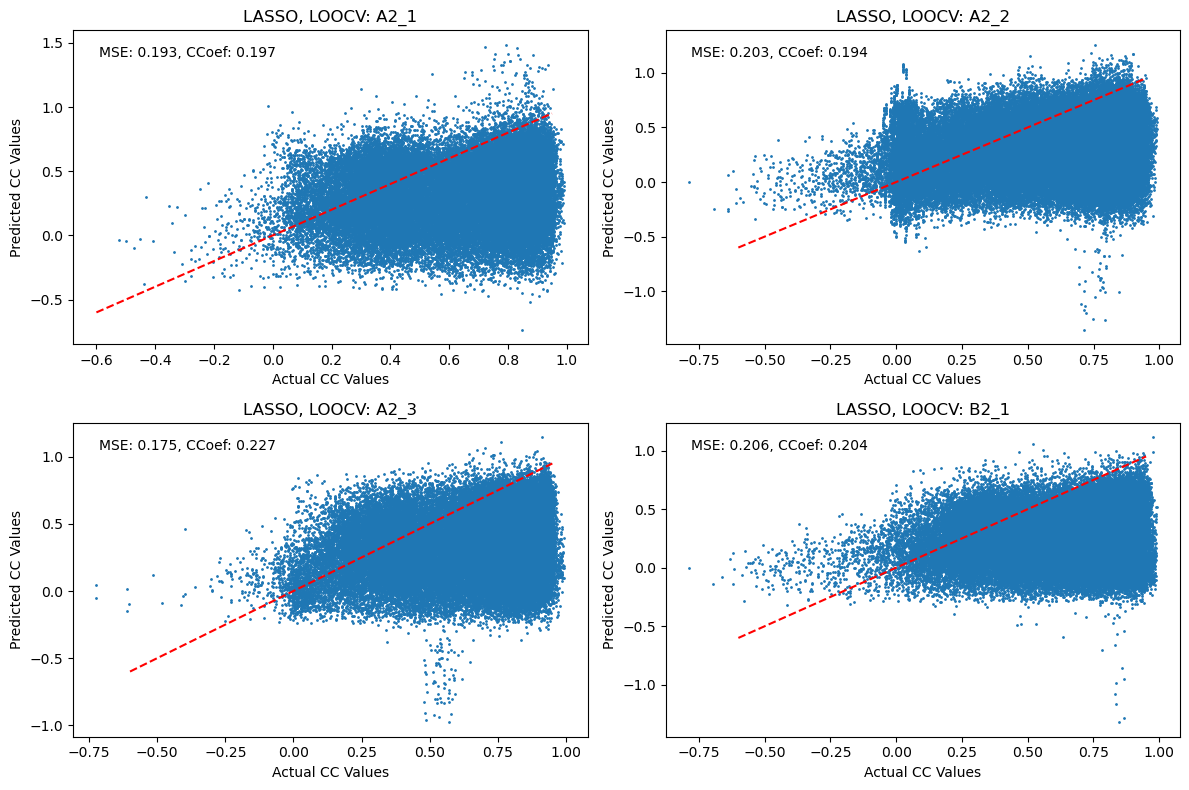

In [27]:
dim_reduce = False
if dim_reduce:
   num_features = 100
   pca = PCA(n_components = num_features)

target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    X_train_trim = scaler.fit_transform(X_train_trim)
    X_test = scaler.transform(X_test)

    if dim_reduce:
         pca.fit(X_train_trim) 
         X_train_trim = pca.transform(X_train_trim)
         X_test = pca.transform(X_test)
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=5, max_iter=1000000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(X_train_trim, y_train_trim)
    
    y_pred_lasso = pipe.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(X_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    """
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    corr_coeff = correlation_matrix[0, 1]
    axs[i].scatter(y_test, y_pred_lasso, s = 1)
    #axs[i].scatter(y_train_trim, y_pred_lasso_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.savefig(f'lassoTrainTrimTestTrainDataAllFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'lassoTrainTrimTestFullDataVAEFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
plt.show()

Indices of Non-Zero PCs/Features Selected by CV model: [ 16  34  37  59  62  64  66  74  82 108 167 179 197 247]
Alpha values tested by CV model: [0.21612633 0.20156014 0.18797566 0.17530673 0.16349164 0.15247285
 0.14219669 0.13261311 0.12367543 0.11534012 0.10756658 0.10031695
 0.09355593 0.08725057 0.08137017 0.0758861  0.07077163 0.06600186
 0.06155355 0.05740505 0.05353614 0.04992798 0.04656301 0.04342482
 0.04049813 0.03776869 0.03522321 0.03284928 0.03063535 0.02857063
 0.02664506 0.02484928 0.02317452 0.02161263 0.02015601 0.01879757
 0.01753067 0.01634916 0.01524729 0.01421967 0.01326131 0.01236754
 0.01153401 0.01075666 0.0100317  0.00935559 0.00872506 0.00813702
 0.00758861 0.00707716 0.00660019 0.00615536 0.0057405  0.00535361
 0.0049928  0.0046563  0.00434248 0.00404981 0.00377687 0.00352232
 0.00328493 0.00306353 0.00285706 0.00266451 0.00248493 0.00231745
 0.00216126 0.0020156  0.00187976 0.00175307 0.00163492 0.00152473
 0.00142197 0.00132613 0.00123675 0.0011534  0.001

<Figure size 640x480 with 0 Axes>

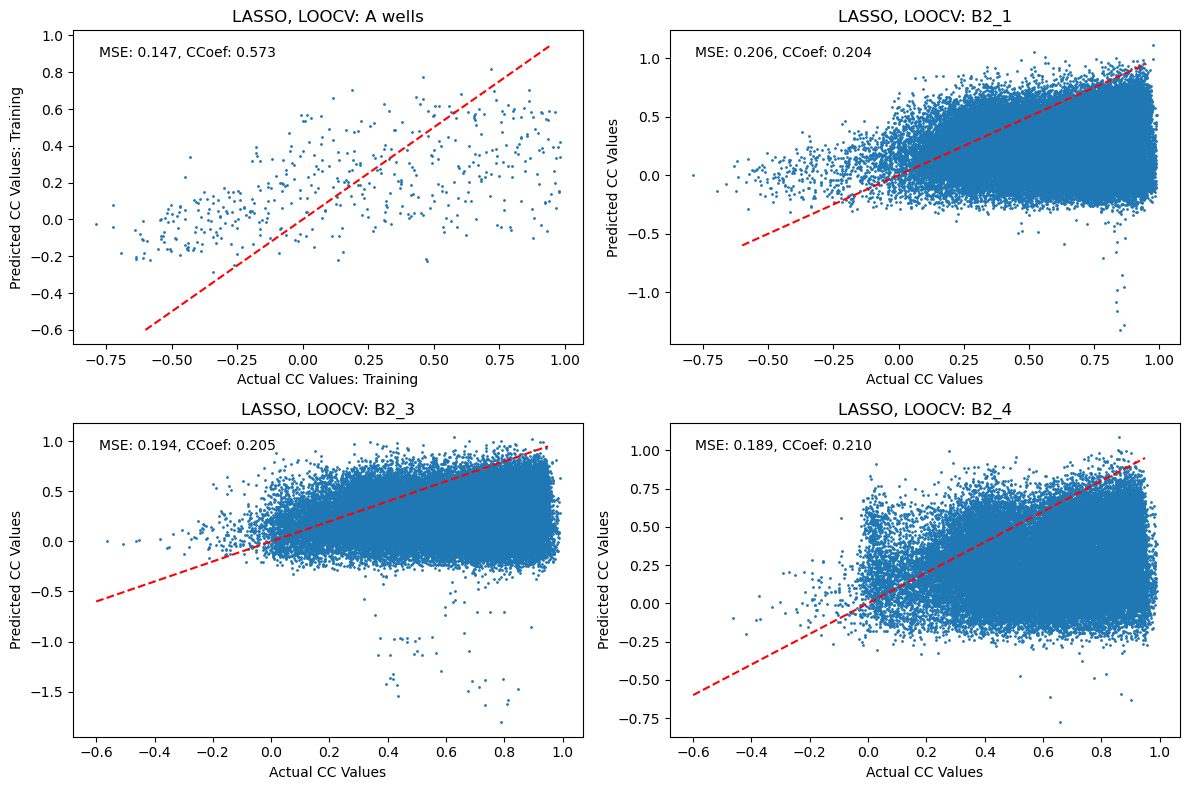

In [35]:
# Training on 'A' wells & Testing on 'B' wells using LASSOCV directly on original features
fname = f'lassoTrainTrimTestFullDataAllFeatBwells_tRgTrajl{trajl}'
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

fovs_indc = np.array([i for i in range(nfovs)])
train_fovs = np.array([0, 1, 2])

X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]

# Least Absolute Shrinkage and Selection Operator (LASSO)
pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('lassocv', LassoCV(cv=5, max_iter=10000000,
                                    #alphas=init_alphas,
                                    tol=1e-5, selection='random', n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)
model = pipe.named_steps['lassocv'] # Access the fitted LassoCV from the pipeline

y_pred_lasso_train = pipe.predict(X_train_trim)
mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
score = model.score(X_train_trim, y_train_trim)
axs[0].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[0].set_xlabel('Actual CC Values: Training')
axs[0].set_ylabel('Predicted CC Values: Training')

################# Which features are considered "important" LOOCV Linear Regression #################
coefficients = model.coef_
non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
corr_coeff = correlation_matrix[0, 1]
axs[0].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
axs[0].set_title('LASSO, LOOCV: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

fov_inds_test = np.setdiff1d(fovs_indc, train_fovs)
data_list = []
data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
data_list.append(data)

for i, fov in enumerate(fov_inds_test):
    test_fov = fov
    
    X_test = X[test_fov]
    y_test = y[test_fov]
    #X_test = X_test[:, indc_predictive_features]
    
    y_pred_lasso = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    score = model.score(X_test, y_test)
    axs[i+1].scatter(y_test, y_pred_lasso, s = 1)
    axs[i+1].set_xlabel('Actual CC Values')
    axs[i+1].set_ylabel('Predicted CC Values')
    
    ################# Which features are considered "important" LOOCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    corr_coeff = correlation_matrix[0, 1]
    
    axs[i+1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i+1].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
    data_list.append(data)
"""
with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
"""
plt.tight_layout()
#plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')
plt.show()

In [29]:
init_alphas = np.array([0.345678, 0.256789, 0.234455, 0.16162068, 0.15072799, 
                        0.14056943, 0.0004603, 0.00042928, 0.00040035, 0.00037336,
                        0.0003482, 0.00032473, 0.00030285, 0.00028244, 0.0002634])

Indices of Non-Zero PCs/Features Selected by CV model: [ 11  23  26  31  32  34  35  42  44  45  49  51  59  71  80  85  86  99
 102 105 110 112 123 129 131 134 135 136 141 142 150 156 160 165 166 170
 181 194 195 199 201 204 219 222 240 244 253]
Alpha values tested by CV model: [3.4567800e-01 2.5678900e-01 2.3445500e-01 1.6162068e-01 1.5072799e-01
 1.4056943e-01 4.6030000e-04 4.2928000e-04 4.0035000e-04 3.7336000e-04
 3.4820000e-04 3.2473000e-04 3.0285000e-04 2.8244000e-04 2.6340000e-04]
Indices of Non-Zero PCs/Features Selected by CV model: [ 11  23  26  31  32  34  35  42  44  45  49  51  59  71  80  85  86  99
 102 105 110 112 123 129 131 134 135 136 141 142 150 156 160 165 166 170
 181 194 195 199 201 204 219 222 240 244 253]
Alpha values tested by CV model: [3.4567800e-01 2.5678900e-01 2.3445500e-01 1.6162068e-01 1.5072799e-01
 1.4056943e-01 4.6030000e-04 4.2928000e-04 4.0035000e-04 3.7336000e-04
 3.4820000e-04 3.2473000e-04 3.0285000e-04 2.8244000e-04 2.6340000e-04]
Indices of N

<Figure size 640x480 with 0 Axes>

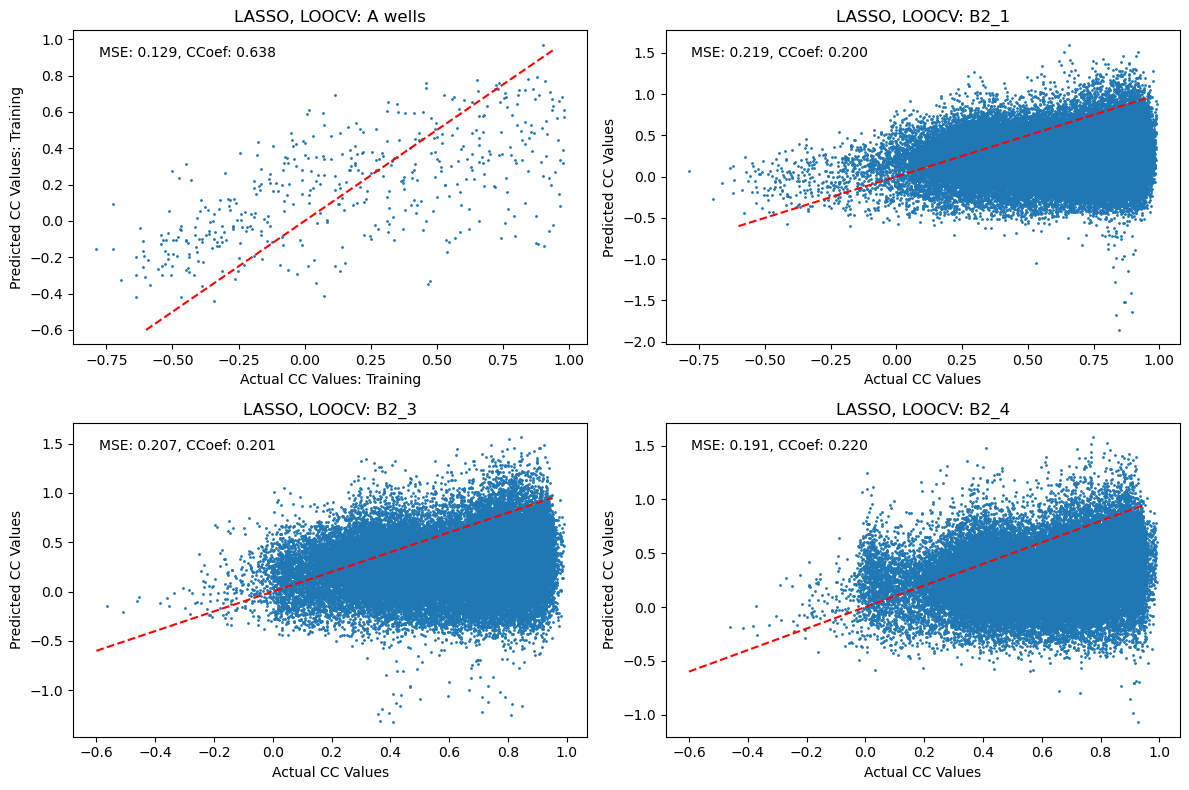

In [30]:
# Training on 'A' wells & Testing on 'B' wells using LASSOCV directly on original features
fname = f'lassoTrainTrimTestFullDataAllFeatBwells_tRgTrajl{trajl}'
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

fovs_indc = np.array([i for i in range(nfovs)])
train_fovs = np.array([0, 1, 2])

X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]

# Least Absolute Shrinkage and Selection Operator (LASSO)
pipe = Pipeline([
                ('scaler', StandardScaler()), 
                #('elasticnet_cv', ElasticNetCV(cv=5, max_iter=1000000, random_state=0,
                                               #alphas=init_alphas,
                                               #l1_ratio=[.1, .5, .7, .9, .95, 1], n_jobs=-1))
                ('lassocv', LassoCV(cv=5, max_iter=10000000,
                                    alphas=init_alphas,
                                    tol=1e-5, selection='random', n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)
model = pipe.named_steps['lassocv'] # Access the fitted LassoCV from the pipeline
#model = pipe.named_steps['elasticnet_cv'] # Access the fitted ElasticNetCV from the pipeline

y_pred_lasso_train = pipe.predict(X_train_trim)
mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
score = model.score(X_train_trim, y_train_trim)
axs[0].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[0].set_xlabel('Actual CC Values: Training')
axs[0].set_ylabel('Predicted CC Values: Training')

################# Which features are considered "important" LOOCV Linear Regression #################
coefficients = model.coef_
non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
corr_coeff = correlation_matrix[0, 1]
axs[0].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
axs[0].set_title('LASSO, LOOCV: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

fov_inds_test = np.setdiff1d(fovs_indc, train_fovs)
data_list = []
data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
data_list.append(data)

for i, fov in enumerate(fov_inds_test):
    test_fov = fov
    
    X_test = X[test_fov]
    y_test = y[test_fov]
    #X_test = X_test[:, indc_predictive_features]
    
    y_pred_lasso = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    score = model.score(X_test, y_test)
    axs[i+1].scatter(y_test, y_pred_lasso, s = 1)
    axs[i+1].set_xlabel('Actual CC Values')
    axs[i+1].set_ylabel('Predicted CC Values')
    
    ################# Which features are considered "important" LOOCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
    print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
    corr_coeff = correlation_matrix[0, 1]
    axs[i+1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i+1].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
    data_list.append(data)
"""
with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
"""
plt.tight_layout()
#plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')
plt.show()

Indices of Non-Zero PCs/Features Selected by CV model: [ 16  34  37  57  59  60  62  64  66  74  77  82 102 108 124 126 156 161
 167 179 196 197 198 206 218 228 244 247]
Alpha values tested by CV model: [[2.16126328e+00 2.01560136e+00 1.87975658e+00 1.75306728e+00
  1.63491641e+00 1.52472852e+00 1.42196692e+00 1.32613111e+00
  1.23675431e+00 1.15340121e+00 1.07566583e+00 1.00316955e+00
  9.35559279e-01 8.72505715e-01 8.13701750e-01 7.58860975e-01
  7.07716285e-01 6.60018576e-01 6.15535533e-01 5.74050498e-01
  5.35361416e-01 4.99279848e-01 4.65630058e-01 4.34248150e-01
  4.04981278e-01 3.77686896e-01 3.52232063e-01 3.28492801e-01
  3.06353485e-01 2.85706286e-01 2.66450638e-01 2.48492757e-01
  2.31745177e-01 2.16126328e-01 2.01560136e-01 1.87975658e-01
  1.75306728e-01 1.63491641e-01 1.52472852e-01 1.42196692e-01
  1.32613111e-01 1.23675431e-01 1.15340121e-01 1.07566583e-01
  1.00316955e-01 9.35559279e-02 8.72505715e-02 8.13701750e-02
  7.58860975e-02 7.07716285e-02 6.60018576e-02 6.1553

<Figure size 640x480 with 0 Axes>

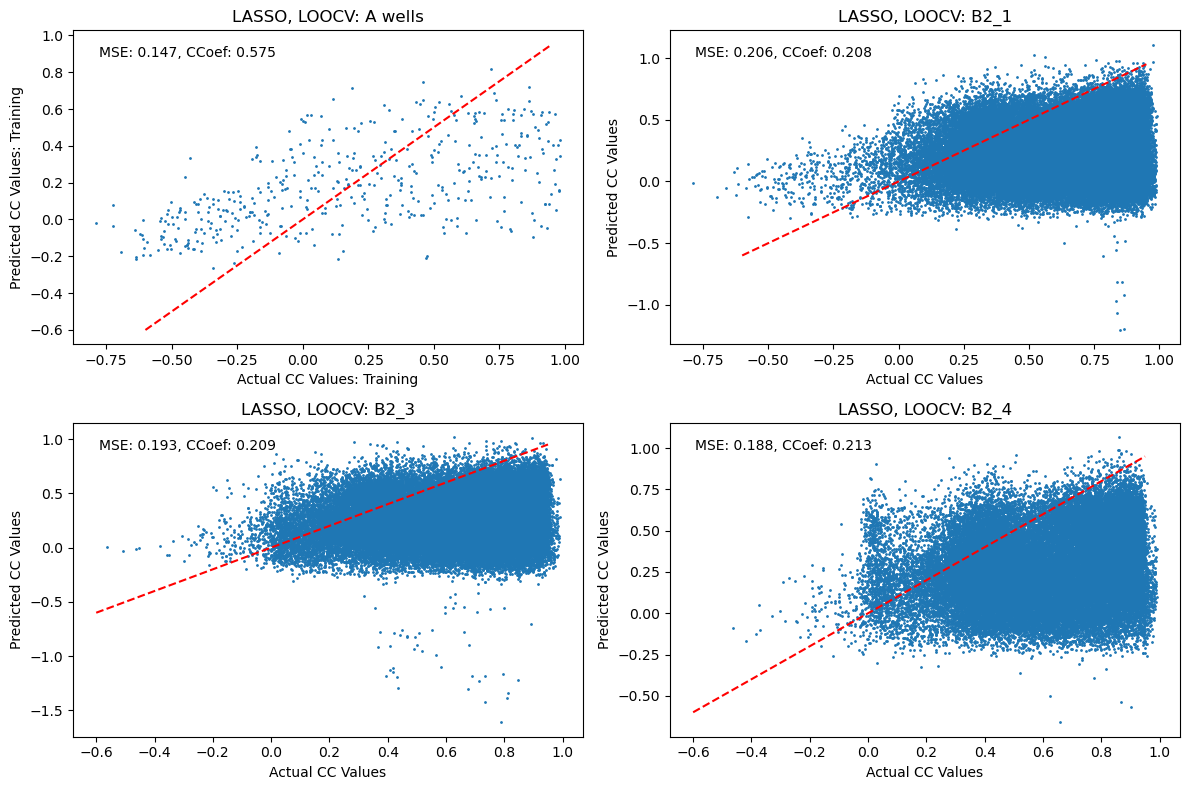

In [34]:
# Training on 'A' wells & Testing on 'B' wells using ElasticNetCV directly on original features
fname = f'lassoTrainTrimTestFullDataAllFeatBwells_tRgTrajl{trajl}'
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()

fovs_indc = np.array([i for i in range(nfovs)])
train_fovs = np.array([0, 1, 2])

X_train = np.zeros((0, X[0].shape[1]))
y_train = np.zeros(0)
for it_fov in train_fovs:
    X_train = np.append(X_train, X[it_fov], axis = 0)
    y_train = np.append(y_train, y[it_fov], axis = 0)
############################ Trim Training Data ############################ 
trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
original_indices_train = []
y_train_trim = []
    
for it in range(trimmed_cc_train['original_index'].shape[0]):
    original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
    y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
original_indices_train = np.array(original_indices_train)
y_train_trim = np.array(y_train_trim)
X_train_trim = X_train[original_indices_train, :]

pipe = Pipeline([
                ('scaler', StandardScaler()), 
                ('elasticnet_cv', ElasticNetCV(cv=5, max_iter=1000000, random_state=0,
                                               l1_ratio=[.1, .5, .7, .9, .95, 1], n_jobs=-1))
                ])
pipe.fit(X_train_trim, y_train_trim)
model = pipe.named_steps['elasticnet_cv'] # Access the fitted ElasticNetCV from the pipeline

y_pred_lasso_train = pipe.predict(X_train_trim)
mse = mean_squared_error(y_train_trim, y_pred_lasso_train)
correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
score = model.score(X_train_trim, y_train_trim)
axs[0].scatter(y_train_trim, y_pred_lasso_train, s = 1)
axs[0].set_xlabel('Actual CC Values: Training')
axs[0].set_ylabel('Predicted CC Values: Training')

################# Which features are considered "important" ElasticNetCV Linear Regression #################
coefficients = model.coef_
non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
#print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
corr_coeff = correlation_matrix[0, 1]
axs[0].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
axs[0].set_title('ElasticNetCV: A wells')
axs[0].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
            transform=axs[0].transAxes, 
            verticalalignment='top',
            horizontalalignment='left')

fov_inds_test = np.setdiff1d(fovs_indc, train_fovs)
data_list = []
data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
data_list.append(data)

for i, fov in enumerate(fov_inds_test):
    test_fov = fov
    
    X_test = X[test_fov]
    y_test = y[test_fov]
    #X_test = X_test[:, indc_predictive_features]
    
    y_pred_lasso = pipe.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    score = model.score(X_test, y_test)
    axs[i+1].scatter(y_test, y_pred_lasso, s = 1)
    axs[i+1].set_xlabel('Actual CC Values')
    axs[i+1].set_ylabel('Predicted CC Values')
    
    ################# Which features are considered "important" ElasticNetCV Linear Regression #################
    coefficients = model.coef_
    non_zero_indices = np.where(coefficients != 0)[0] # Identify non-zero coefficients (features to keep)
    print(f"Indices of Non-Zero PCs/Features Selected by CV model: {non_zero_indices}")
    #print(f"Alpha values tested by CV model: {model.alphas_}") # alpha values tested
    corr_coeff = correlation_matrix[0, 1]
    axs[i+1].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i+1].set_title(f'ElasticNetCV: {fovs[fov]}')
    axs[i+1].text(0.05, 0.95, f'MSE: {mse:.3f}, CCoef: {corr_coeff:.3f}', 
                  transform=axs[i+1].transAxes, 
                  verticalalignment='top',
                  horizontalalignment='left')
    data = {'Correlation coefficient': corr_coeff, 'Score': score, 'mse': mse}
    data_list.append(data)
"""
with open(f'{fname}.json', 'w') as fout:
    json.dump(data_list, fout, indent=4)
"""
plt.tight_layout()
#plt.savefig(f'{fname}.png', dpi = 400, bbox_inches='tight')
plt.show()

In [ ]:
n_bins = 50
plt.clf()
for fov in fovs_indc:
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    
    plt.figure(figsize = (9, 6))
    plt.hist(y_train, bins = n_bins, alpha = 0.5, color = 'g', label = 'Trainng Set')
    plt.hist(y_test, bins = n_bins, alpha = 0.5, color='r', label = 'Test Set')
    plt.xlabel('CC Values')
    plt.ylabel('Frequency')
    plt.title('Histogram of CC Values')
    plt.legend()
    plt.grid(True)
    plt.show()

## Simple Linear Regression

In [ ]:
model_linRegFOV = LinearRegression(n_jobs=-1) 

## Linear Regressor with Stochastic Gradient Descent (SGD)

In [ ]:
 model_lrSGD = SGDRegressor(max_iter=10000, tol=1e-4, learning_rate='invscaling', eta0=0.01)

In [ ]:
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)

    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train) 
        Xpca_train = pca.transform(X_train)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features according to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train = X_train[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    #model_linRegFOV.fit(Xpca_train, y_train)
    model_lrSGD.fit(Xpca_train, y_train) # Linear Regression with Stochastic Gradient Descent
    # Predict on the test set: Linear Regression
    #y_pred_linRegLOFO = model_linRegFOV.predict(Xpca_test)
    
    y_pred_linRegLOFO = model_lrSGD.predict(Xpca_test) # Linear Regression with Stochastic Gradient Descent
    mse_test = mean_squared_error(y_test, y_pred_linRegLOFO)
    correlation_matrix = np.corrcoef(y_test, y_pred_linRegLOFO)
    """
    # Predict on the training set
    #y_pred_linRegLOFO_train = model_linRegFOV.predict(Xpca_train) # Simple Linear Regression
    y_pred_linRegLOFO_train = model_lrSGD.predict(Xpca_train) # Linear Regression with Stochastic Gradient Descent
    mse_train = mean_squared_error(y_train, y_pred_linRegLOFO_train)
    correlation_matrix = np.corrcoef(y_train, y_pred_linRegLOFO_train)
    """
    corr_coeff = correlation_matrix[0, 1]
    axs[i].scatter(y_test, y_pred_linRegLOFO, s = 1)
    #axs[i].scatter(y_train, y_pred_linRegLOFO_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'Linear Regression, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}',
                transform=axs[i].transAxes,
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
plt.savefig(f'linRegTest4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'linRegTrain4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

In [ ]:
fovs_indc = [i for i in range(nfovs)]
fovs_indc = np.array(fovs_indc)
exclude_fovs = np.array([4, 5])
exclude_cond = True #exclude_cond = False
if exclude_cond:
    fovs_indc = np.delete(fovs_indc, exclude_fovs)
    print(f'Final Field of Views to be analyzed: {fovs_indc}')
else: 
    print(f'Final Field of Views to be analyzed: {fovs_indc}')

In [ ]:
num_features = 100
pca = PCA(n_components = num_features)

In [ ]:
def unique_predictive_features(n_top_cont_features = 5):
    loadings = pca.components_
    feature_inds = np.array([]).astype(int)
    for i, pc in enumerate(loadings):
        # Gets indices of the top features for each PC
        top_features_indices = np.argsort(np.abs(pc))[-n_top_cont_features:] 
        #print(f"Top {n_cf} contributing feature indices for PC{i+1}: {top_features_indices}")
        feature_inds = np.append(feature_inds, top_features_indices)
    unique_feature_inds = np.unique(feature_inds)

    return unique_feature_inds

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############################ Trim Training Data ############################ 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    """
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    corr_coeff = correlation_matrix[0, 1]
    #axs[i].scatter(y_test, y_pred_lasso, s = 1)
    axs[i].scatter(y_train_trim, y_pred_lasso_train, s = 1)
    axs[i].plot([-0.6, 0.95], [-0.6, 0.95], 'r--') # Best fit line 
    #axs[i].set_xlabel('Actual CC Values')
    #axs[i].set_ylabel('Predicted CC Values')
    axs[i].set_xlabel('Actual CC Values: Training')
    axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    #axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
plt.savefig(f'lassoTrainTrimTestTrainDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
#plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVs_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

Indices of top predictive features from LASSOCV on snapshots: [25 31 36 42 43 55 62 77 78 92 93 94]

In [ ]:
target_density = 10; n_bins = 50
plt.clf()
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (12, 8))
axs = axs.flatten()
for i, fov in enumerate(fovs_indc):
    test_fov = fov
    train_fovs = np.setdiff1d(fovs_indc, test_fov)
    X_test = X[test_fov]
    y_test = y[test_fov]
    X_train = np.zeros((0, X[0].shape[1]))
    y_train = np.zeros(0)
    for it_fov in train_fovs:
        X_train = np.append(X_train, X[it_fov], axis = 0)
        y_train = np.append(y_train, y[it_fov], axis = 0)
    ############## Trim Training Data ############## 
    trimmed_cc_train = trim_cc_vals(y_train, n_bins, target_density)
    original_indices_train = []
    y_train_trim = []
    
    for it in range(trimmed_cc_train['original_index'].shape[0]):
        original_indices_train.append(trimmed_cc_train['original_index'].iloc[it])
        y_train_trim.append(trimmed_cc_train['CC'].iloc[it])
    
    original_indices_train = np.array(original_indices_train)
    y_train_trim = np.array(y_train_trim)
    X_train_trim = X_train[original_indices_train, :]
    dim_reduction = False
    if dim_reduction:
        ############### Dimensional reduction on trimmed training data ###############
        pca.fit(X_train_trim) 
        Xpca_train_trim = pca.transform(X_train_trim)
        Xpca_test = pca.transform(X_test)
    else: 
        # Select features accroding to their predictive performance 
        top_contFeat_pc = 2 # Number of top contributing features in each PC
        #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
        indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
        print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
        Xpca_train_trim = X_train_trim[:, indc_predictive_features]
        Xpca_test = X_test[:, indc_predictive_features]
    
    # Least Absolute Shrinkage and Selection Operator (LASSO)
    pipe = Pipeline([
                    ('scaler', StandardScaler()), 
                    ('lassocv', LassoCV(cv=100, max_iter=100000, tol=1e-5, selection='random', n_jobs=-1))
                    ])
    pipe.fit(Xpca_train_trim, y_train_trim)
    
    y_pred_lasso = pipe.predict(Xpca_test)
    mse_test = mean_squared_error(y_test, y_pred_lasso)
    correlation_matrix = np.corrcoef(y_test, y_pred_lasso)
    """
    y_pred_lasso_train = pipe.predict(Xpca_train_trim)
    mse_train = mean_squared_error(y_train_trim, y_pred_lasso_train)
    correlation_matrix = np.corrcoef(y_train_trim, y_pred_lasso_train)
    """
    ################### Which features are considered "important" by LASSO ###################
    coefficients = pipe.named_steps['lassocv'].coef_
    # Identify non-zero coefficients (features to keep)
    non_zero_indices = np.where(coefficients != 0)[0]
    print(f"Indices of Non-Zero PCs/Features Selected by LassoCV: {non_zero_indices}")
    
    corr_coeff = correlation_matrix[0, 1]
    xy = np.vstack([y_test, y_pred_lasso])
    #xy = np.vstack([y_train_trim, y_pred_lasso_train])
    z = scipy.stats.gaussian_kde(xy)(xy)
    
    sc = axs[i].scatter(y_test, y_pred_lasso, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_test, y_pred_lasso, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_test, y_pred_lasso, z, levels=14, cmap="RdBu_r")
    """
    sc = axs[i].scatter(y_train_trim, y_pred_lasso_train, c=z, s=1, label='Data Points')
    axs[i].tricontour(y_train_trim, y_pred_lasso_train, z, levels=14, linewidths=0.5, colors='k')
    contour_plot = axs[i].tricontourf(y_train_trim, y_pred_lasso_train, z, levels=14, cmap="RdBu_r")
    """
    # Add a colorbar to each subplot
    fig.colorbar(contour_plot, ax=axs[i], label='Density')
    axs[i].set_xlabel('Actual CC Values')
    axs[i].set_ylabel('Predicted CC Values')
    #axs[i].set_xlabel('Actual CC Values: Training')
    #axs[i].set_ylabel('Predicted CC Values: Training')
    axs[i].set_title(f'LASSO, LOOCV: {fovs[fov]}')
    #axs[i].text(0.05, 0.95, f'MSE: {mse_train:.3f}, CCoef: {corr_coeff:.3f}',
    axs[i].text(0.05, 0.95, f'MSE: {mse_test:.3f}, CCoef: {corr_coeff:.3f}', 
                transform=axs[i].transAxes, 
                verticalalignment='top',
                horizontalalignment='left')
plt.tight_layout()
#plt.show()
#plt.savefig(f'lassoTrainTrimTestTrimDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')
plt.savefig(f'lassoTrainTrimTestFullDataSupFeat4FOVsContour_trajl{trajl}.png', dpi = 400, bbox_inches='tight')

In [ ]:
num_features = 10
pca_nn = PCA(n_components = num_features)

In [ ]:
dim_reduction = False
if dim_reduction:
    ############### Dimensional reduction on trimmed training data ###############
    pca_nn.fit(X_train_trim) 
    Xpca_train_nn = pca_nn.transform(X_train_trim)
    Xpca_test_nn = pca_nn.transform(X_test)
else: 
    # Select features accroding to their predictive performance 
    top_contFeat_pc = 2 # Number of top contributing features in each PC
    #indc_predictive_features = unique_predictive_features(n_top_cont_features = top_contFeat_pc)
    indc_predictive_features = np.array([25, 31, 36, 42, 43, 55, 62, 77, 78, 92, 93, 94]).astype(int)
    print(f"Indices of top predictive features: {indc_predictive_features}") if i == 0 else None
    Xpca_train_nn = X_train_trim[:, indc_predictive_features]
    Xpca_test_nn = X_test[:, indc_predictive_features]

In [ ]:
scaler = StandardScaler() # Scale features
Xnn_train_scaled = scaler.fit_transform(Xpca_train_nn)
Xnn_test_scaled = scaler.transform(Xpca_test_nn)

In [ ]:
# Define class boundaries
def class_conditions(data, c1, c2):
    conditions = [ data < c1, # Class 1: CC values depicting G2 cell cycle state
                  (data >= c1) & (data < c2), # Class 2: CC values depicting mixed cell-cycle states 
                  data >= c2 # Class 3: CC values > the median, depicting G1 cell cycle state  
                 ]
    return conditions

In [ ]:
# Define class labels for each condition
choices = [0, 1, 2]  # Class labels
c1 = 0.0; c2 = 0.85
# Apply classification on training & test data
y_train_class = np.select(class_conditions(y_train_trim, c1, c2), choices)
y_test_class = np.select(class_conditions(y_test, c1, c2), choices)

# Convert labels to one-hot encoding
y_train_class_onehot = to_categorical(y_train_class)
y_test_class_onehot = to_categorical(y_test_class)

In [ ]:
num_features = indc_predictive_features.size
# Define the Neural Network model architecture
model_nn = Sequential([Input(shape=(num_features, )),  # Input shape for the model (feature vector)
                       Reshape((num_features, 1, 1)),  # Reshape to fit Conv2D layer requirements
                       Conv2D(32, kernel_size=(3, 1), padding='same'), # First CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Conv2D(64, kernel_size=(3, 1), padding='same'), # Second CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Conv2D(128, kernel_size=(3, 1), padding='same', kernel_regularizer=l2(0.01)), # Third CNN layer
                       LeakyReLU(),
                       MaxPooling2D(pool_size=(2, 1)),
                       Dropout(0.2),
                       Flatten(), # Flatten the output of the last CNN layer to feed into a dense layer
                       Dense(256, kernel_regularizer = l2(0.01)),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(128),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(64, kernel_regularizer = l2(0.01)),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(32),
                       LeakyReLU(),
                       Dropout(0.2),
                       Dense(3, activation='softmax')  # Output layer for 3 classes
                       ])
# Compile the model
model_nn.compile(optimizer=Adam(learning_rate=0.001),
                 loss='categorical_crossentropy',
                 metrics=['accuracy'])
# Add early stopping to overcome overfitting 
early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=15,
                               restore_best_weights=True)

In [ ]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_class), y=y_train_class)
class_weights_dict = {i : class_weights[i] for i in range(len(class_weights))}

In [ ]:
# Train the model
history_nn = model_nn.fit(Xnn_train_scaled,
                    y_train_class_onehot,
                    epochs=50,
                    batch_size=10, 
                    validation_split=0.2,
                    class_weight=class_weights_dict,
                    callbacks=[early_stopping])

In [ ]:
#model_nn.save('nn_model.keras') # Save the model
# Predict on the test sets
y_pred_nn = model_nn.predict(Xnn_test_scaled)

In [ ]:
predicted_classes = np.argmax(y_pred_nn, axis=1)
accuracy = accuracy_score(y_test_class, predicted_classes) # Calculate the accuracy of the predictions
print("Accuracy:", accuracy)

In [ ]:
conf_matrix = confusion_matrix(y_test_class, predicted_classes) # Calculate confusion matrix
# Row-normalize the confusion matrix
conf_matrix_normalized = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]

In [ ]:
plt.clf()
plt.figure(figsize = (7, 6))
#sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
sns.heatmap(conf_matrix_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix: Predicted vs Actual CC values of Test Set')
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')
plt.tight_layout()
plt.show()
#plt.savefig('confMatTestPred1B_train3A.png', dpi = 400, bbox_inches='tight')

In [ ]:
plt.clf()
plt.figure(figsize = (9, 5))
plt.subplot(1, 2, 1)
plt.plot(history_nn.history['accuracy'])
plt.plot(history_nn.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('No of Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history_nn.history['loss'])
plt.plot(history_nn.history['val_loss'])
plt.title('Model loss')
plt.xlabel('No of Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

In [ ]:
predictions = y_pred_nn[:, 2]
plt.clf()
plt.figure(figsize=(7, 5))
plt.scatter(y_test, predictions, color='blue', s=1) 
plt.scatter(y_test, y_pred_nn[:, 0], color='red', s=1) 
plt.scatter(y_test, y_pred_nn[:, 1], color='cyan', s=1) 
plt.title('Actual vs. Predicted CC Values: DNN')
plt.xlabel('Actual CC Values')
plt.ylabel('Predicted CC Values')

# Plot a line of perfect prediction
min_val = min(min(y_test), min(predictions))
max_val = max(max(y_test), max(predictions))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--')

plt.grid(True)
plt.show()